In [1]:
import numpy as np
import os

# GPU가 없는 시스템에서는 자동으로 CPU 모드로 실행됨.

# CUDA_VISIBLE_DEVICES 환경 변수를 설정하여 사용 가능한 GPU를 지정
# '1'번 GPU를 사용하도록 설정 (0번부터 시작하여 번호가 매겨짐)
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# TF_FORCE_GPU_ALLOW_GROWTH 환경 변수를 설정하여 TensorFlow가 GPU 메모리를 동적으로 사용할 수 있게 함
# 기본적으로 TensorFlow는 모든 GPU 메모리를 할당하지만, 이 설정을 통해 필요한 만큼만 할당하게 함
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
# 인식할 동작 목록 정의
actions = [
    'one',
    'two',
    'three'
]

# 각 동작에 해당하는 데이터를 로드하여 하나의 배열로 연결
data = np.concatenate([
    np.load('dataset/seq_one_1716892952.npy'),
    np.load('dataset/seq_two_1716892952.npy'),
    np.load('dataset/seq_three_1716892952.npy')
], axis=0) # 첫 번째 축(axis=0)을 따라 데이터를 연결

# 연결된 데이터의 형태 출력
data.shape # 예를 들어, (900, 30, 68)처럼 연결된 데이터의 차원 정보를 출력

(2370, 30, 100)

In [3]:
# 데이터에서 입력 데이터(x_data)와 라벨(labels) 분리
# x_data는 마지막 축을 제외한 모든 데이터를 포함
# labels는 마지막 축의 첫 번째 값을 사용하여 각 시퀀스의 라벨로 설정
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

# 분리된 데이터의 형태 출력
print(x_data.shape)   # 예를 들어, (900, 30, 67)
print(labels.shape)   # 예를 들어, (900,)

(2370, 30, 99)
(2370,)


In [4]:
# TensorFlow Keras의 to_categorical을 사용하여 라벨을 원-핫 인코딩
from tensorflow.keras.utils import to_categorical

# 원-핫 인코딩된 라벨 데이터 생성
y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape  # 예를 들어, (900, 3)

(2370, 3)

In [5]:
# sklearn의 train_test_split을 사용하여 데이터셋을 학습 데이터와 검증 데이터로 분할
from sklearn.model_selection import train_test_split

# 데이터 타입을 float32로 변환
x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

# 학습 데이터와 검증 데이터로 분할 (10%는 검증 데이터로 사용)
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

# 분할된 데이터셋의 형태 출력
print(x_train.shape, y_train.shape)  # 예를 들어, (810, 30, 67) (810, 3)
print(x_val.shape, y_val.shape)      # 예를 들어, (90, 30, 67) (90, 3)

(2133, 30, 99) (2133, 3)
(237, 30, 99) (237, 3)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 모델을 Sequential 형태로 정의
model = Sequential([
    # 첫 번째 LSTM 레이어
    # 유닛 수: 64, 활성화 함수: ReLU, 입력 형태: (시퀀스 길이, 피처 수)
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    # 두 번째 Dense 레이어
    # 유닛 수: 32, 활성화 함수: ReLU
    Dense(32, activation='relu'),
    # 세 번째 Dense 레이어 (출력 레이어)
    # 유닛 수: 인식할 동작의 수, 활성화 함수: 소프트맥스
    Dense(len(actions), activation='softmax')
])

# 모델 컴파일
# 옵티마이저: Adam, 손실 함수: categorical_crossentropy, 메트릭: 정확도(acc)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# 모델 요약 출력
model.summary()


C:\Users\by130\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          41,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,163 (172.51 KB)

 Trainable params: 44,163 (172.51 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# 모델 학습
history = model.fit(
    x_train,              # 학습 데이터
    y_train,              # 학습 라벨
    validation_data=(x_val, y_val),  # 검증 데이터 및 라벨
    epochs=200,           # 총 학습 에포크 수
    callbacks=[
        # ModelCheckpoint 콜백: 최적의 모델을 저장
        ModelCheckpoint(
            'models/model.keras',  # 모델 파일 저장 경로
            monitor='val_acc',         # 검증 정확도를 모니터링
            verbose=1,                 # 저장 시 메시지 출력
            save_best_only=True,       # 최상의 검증 정확도를 가진 모델만 저장
            mode='auto'                # 최적화 기준 모드 자동 설정
        ),
        # ReduceLROnPlateau 콜백: 학습 속도 조정
        ReduceLROnPlateau(
            monitor='val_acc',         # 검증 정확도를 모니터링
            factor=0.5,                # 학습 속도를 줄이는 비율
            patience=50,               # 50 에포크 동안 개선이 없으면 학습 속도를 줄임
            verbose=1,                 # 학습 속도 조정 시 메시지 출력
            mode='auto'                # 최적화 기준 모드 자동 설정
        )
    ]
)


Epoch 1/200
61/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.3659 - loss: 61.6132
Epoch 1: val_acc improved from -inf to 0.68776, saving model to models/model.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - acc: 0.3772 - loss: 58.8551 - val_acc: 0.6878 - val_loss: 5.9576 - learning_rate: 0.0010
Epoch 2/200
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.7646 - loss: 3.5504
Epoch 2: val_acc improved from 0.68776 to 0.84810, saving model to models/model.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.7648 - loss: 3.5410 - val_acc: 0.8481 - val_loss: 2.0928 - learning_rate: 0.0010
Epoch 3/200
62/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.8560 - loss: 1.8322
Epoch 3: val_acc improved from 0.84810 to 0.91139, saving model to models/model.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.8578 - loss: 1.8060 - val_acc: 0.9114 - val_loss: 1.3126 - learning_rate: 0.0010
Epoch 4/200
61/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.8904 - loss: 1.3510
Epoch 4: val_acc improved from 0.91

Epoch 26/200
62/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.7458 - loss: 3.1128
Epoch 26: val_acc did not improve from 0.95781
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.7454 - loss: 3.1254 - val_acc: 0.7764 - val_loss: 2.3749 - learning_rate: 0.0010
Epoch 27/200
61/67 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.7949 - loss: 1.9353
Epoch 27: val_acc did not improve from 0.95781
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.7950 - loss: 1.9038 - val_acc: 0.8523 - val_loss: 1.0169 - learning_rate: 0.0010
Epoch 28/200
61/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.8550 - loss: 0.8293
Epoch 28: val_acc did not improve from 0.95781
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.8551 - loss: 0.8294 - val_acc: 0.8819 - val_loss: 0.8172 - learning_rate: 0.0010
Epoch 29/200
65/67 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.8833 - loss: 0.7426
Epoch 29: val_acc did not improve from 0.95781
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.8836 - loss: 0.7374 - val_acc: 0.8734 - val_loss: 0.5

Epoch 51/200
63/67 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9891 - loss: 0.0385
Epoch 51: val_acc did not improve from 0.99578
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9888 - loss: 0.0397 - val_acc: 0.9747 - val_loss: 0.2234 - learning_rate: 0.0010
Epoch 52/200
62/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9667 - loss: 0.1417
Epoch 52: val_acc did not improve from 0.99578
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.9669 - loss: 0.1403 - val_acc: 0.9831 - val_loss: 0.0475 - learning_rate: 0.0010
Epoch 53/200
65/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9780 - loss: 0.1523
Epoch 53: val_acc did not improve from 0.99578
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.9782 - loss: 0.1507 - val_acc: 0.9916 - val_loss: 0.0466 - learning_rate: 0.0010
Epoch 54/200
65/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9787 - loss: 0.1600
Epoch 54: val_acc did not improve from 0.99578
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.9784 - loss: 0.1626 - val_acc: 0.9831 - val_loss: 0.

59/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9910 - loss: 0.0558
Epoch 101: val_acc did not improve from 1.00000
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.9908 - loss: 0.0570 - val_acc: 0.9958 - val_loss: 0.0046 - learning_rate: 0.0010
Epoch 102/200
62/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9893 - loss: 0.0758
Epoch 102: val_acc did not improve from 1.00000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9896 - loss: 0.0729 - val_acc: 1.0000 - val_loss: 8.3795e-04 - learning_rate: 0.0010
Epoch 103/200
61/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9956 - loss: 0.0161
Epoch 103: val_acc did not improve from 1.00000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9954 - loss: 0.0166 - val_acc: 1.0000 - val_loss: 8.9060e-04 - learning_rate: 0.0010
Epoch 104/200
61/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9815 - loss: 0.1302
Epoch 104: val_acc did not improve from 1.00000
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.9816 - loss: 0.1320 - val_acc: 1.0000 - val_loss: 5

Epoch 126/200
62/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9871 - loss: 0.1566
Epoch 126: val_acc did not improve from 1.00000
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.9868 - loss: 0.1595 - val_acc: 0.9873 - val_loss: 0.3387 - learning_rate: 5.0000e-04
Epoch 127/200
65/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9783 - loss: 0.1452
Epoch 127: val_acc did not improve from 1.00000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9782 - loss: 0.1454 - val_acc: 0.9873 - val_loss: 0.0308 - learning_rate: 5.0000e-04
Epoch 128/200
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9890 - loss: 0.0675
Epoch 128: val_acc did not improve from 1.00000
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.9889 - loss: 0.0682 - val_acc: 0.9536 - val_loss: 0.4057 - learning_rate: 5.0000e-04
Epoch 129/200
65/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9945 - loss: 0.0186
Epoch 129: val_acc did not improve from 1.00000
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.9944 - loss: 0.0186 - val_acc: 1.

Epoch 151/200
62/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 1.0000 - loss: 7.7217e-05
Epoch 151: val_acc did not improve from 1.00000
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 1.0000 - loss: 7.9258e-05 - val_acc: 1.0000 - val_loss: 5.4576e-04 - learning_rate: 5.0000e-04
Epoch 152/200
60/67 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 1.0000 - loss: 8.9499e-05
Epoch 152: val_acc did not improve from 1.00000
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 1.0000 - loss: 8.8308e-05 - val_acc: 1.0000 - val_loss: 6.2617e-04 - learning_rate: 5.0000e-04
Epoch 153/200
59/67 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 1.0000 - loss: 5.5278e-05
Epoch 153: val_acc did not improve from 1.00000
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 1.0000 - loss: 5.9258e-05 - val_acc: 1.0000 - val_loss: 4.0857e-04 - learning_rate: 5.0000e-04
Epoch 154/200
64/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 1.0000 - loss: 8.7055e-05
Epoch 154: val_acc did not improve from 1.00000
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - 

Epoch 175/200
64/67 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 1.0000 - loss: 9.1307e-05
Epoch 175: val_acc did not improve from 1.00000
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 1.0000 - loss: 9.0772e-05 - val_acc: 1.0000 - val_loss: 2.5283e-04 - learning_rate: 2.5000e-04
Epoch 176/200
58/67 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 1.0000 - loss: 3.5360e-05
Epoch 176: val_acc did not improve from 1.00000
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 1.0000 - loss: 4.2664e-05 - val_acc: 1.0000 - val_loss: 2.1101e-04 - learning_rate: 2.5000e-04
Epoch 177/200
60/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 1.0000 - loss: 1.0954e-04
Epoch 177: val_acc did not improve from 1.00000
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 1.0000 - loss: 1.0787e-04 - val_acc: 1.0000 - val_loss: 2.0084e-04 - learning_rate: 2.5000e-04
Epoch 178/200
65/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 1.0000 - loss: 1.1818e-04
Epoch 178: val_acc did not improve from 1.00000
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - 

Epoch 199/200
65/67 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 1.0000 - loss: 7.2475e-05
Epoch 199: val_acc did not improve from 1.00000
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 1.0000 - loss: 7.2598e-05 - val_acc: 1.0000 - val_loss: 2.4060e-04 - learning_rate: 2.5000e-04
Epoch 200/200
65/67 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 1.0000 - loss: 5.0278e-05
Epoch 200: val_acc did not improve from 1.00000
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 1.0000 - loss: 5.1246e-05 - val_acc: 1.0000 - val_loss: 1.6426e-04 - learning_rate: 2.5000e-04


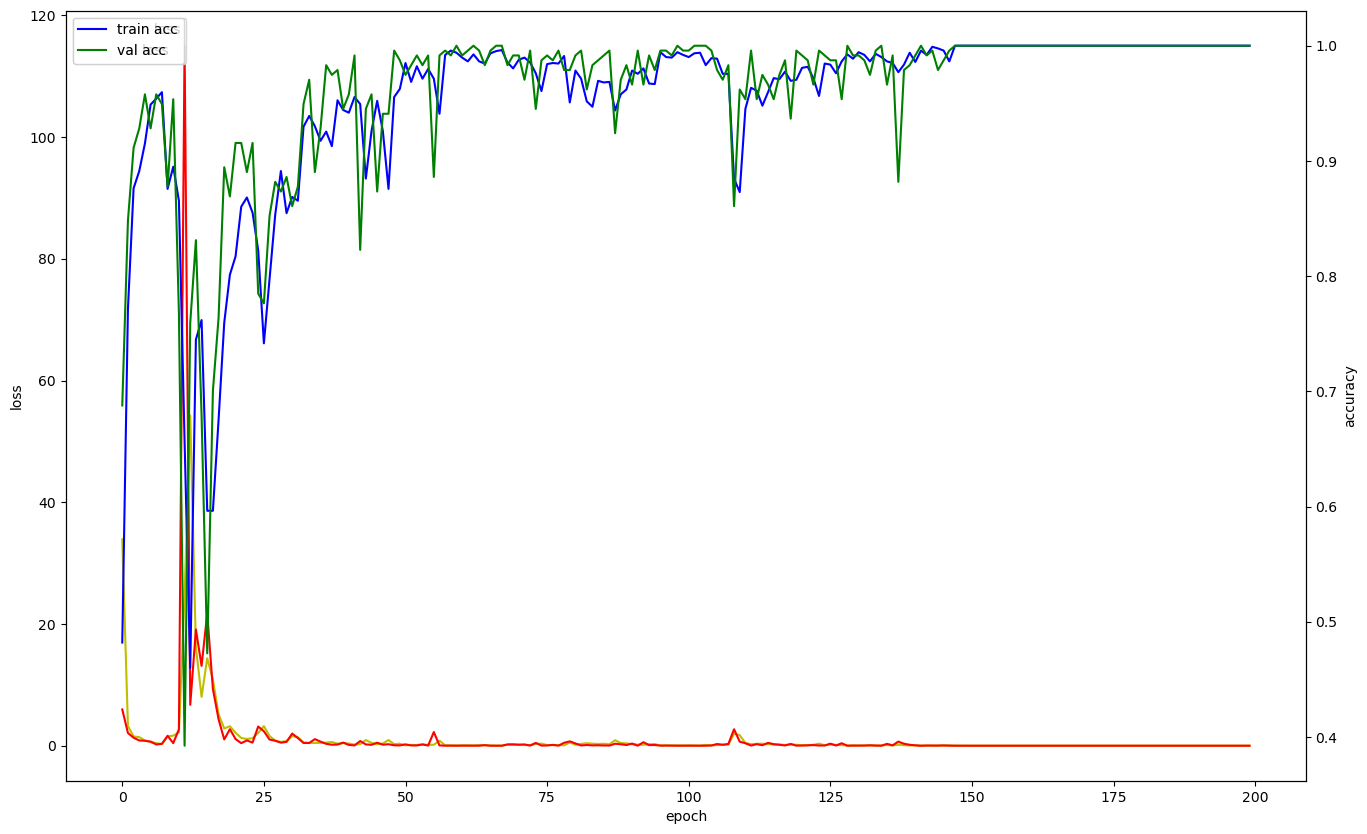

In [8]:
import matplotlib.pyplot as plt

# 그래프 생성
fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

# 손실 그래프 설정
loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

# 정확도 그래프 설정
acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

# 그래프 출력
plt.show()


In [9]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

# 저장된 모델 로드
model = load_model('models/model.keras')

# 검증 데이터를 사용하여 모델의 예측 수행
y_pred = model.predict(x_val)

# 다중 라벨 혼동 행렬 계산
confusion_matrices = multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

# 다중 라벨 혼동 행렬 출력
confusion_matrices


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


array([[[168,   0],
        [  0,  69]],

       [[145,   0],
        [  0,  92]],

       [[161,   0],
        [  0,  76]]], dtype=int64)

In [10]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model
import os

# 모델 파일 경로 정의
model_file = 'models/model.keras'

try:
    # 파일 존재 여부 확인
    if os.path.exists(model_file):
        # 모델 로드
        model = load_model(model_file)

        # 검증 데이터에 대한 예측 수행
        y_pred = model.predict(x_val)

        # 다중 라벨 혼동 행렬 계산
        confusion_matrices = multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

        # 혼동 행렬 출력
        print(confusion_matrices)
    else:
        raise FileNotFoundError(f"모델 파일 '{model_file}'을 찾을 수 없습니다.")
except Exception as e:
    print("오류가 발생했습니다:", e)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[[[168   0]
  [  0  69]]

 [[145   0]
  [  0  92]]

 [[161   0]
  [  0  76]]]
